Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [158]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Rescaling, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

In [159]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [160]:
##from google.colab import drive
##drive.mount('/content/drive')

In [161]:
#!cp -r /content/drive/MyDrive/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration /content/data/

In [162]:
#!mv /content/data/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration /content/data/SkinCancer

In [ ]:
#!cp -r /content/data/SkinCancer /content/data/SkinCancerOriginal

In [163]:
#drive.flush_and_unmount()

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [164]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/data/SkinCancerOriginal/Train/")
data_dir_test = pathlib.Path("/content/data/SkinCancerOriginal/Test/")

In [165]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [166]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [167]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    class_names= ["actinic keratosis", "basal cell carcinoma", "dermatofibroma", "melanoma", "nevus",
                  "pigmented benign keratosis", "seborrheic keratosis", "squamous cell carcinoma",
                  "vascular lesion"],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="both",
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [168]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

In [169]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

num_classes = 9

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

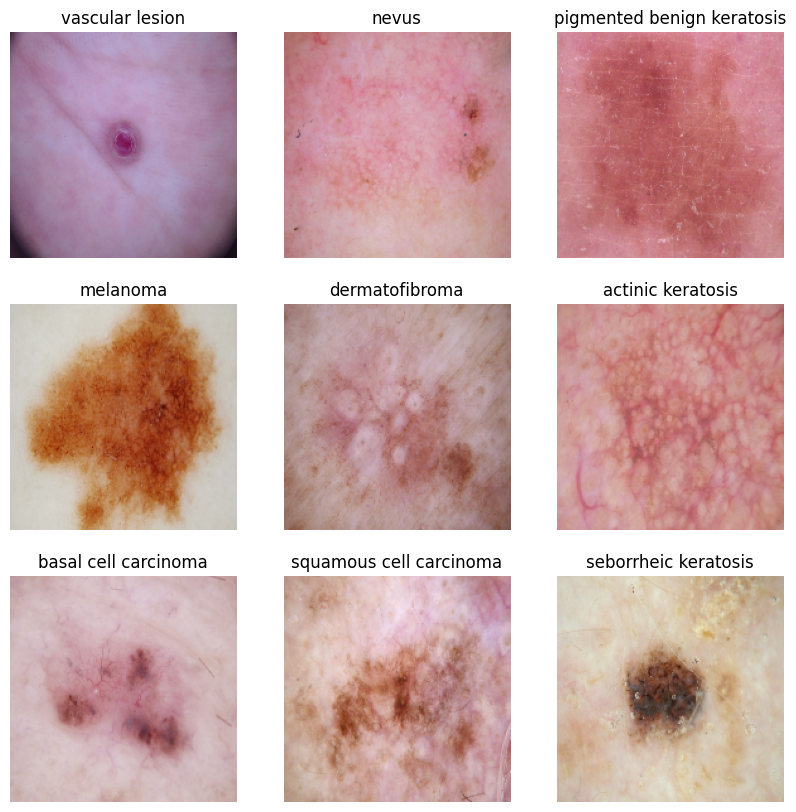

In [170]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
def get_int_label(label):
    for i in range(0,10):
        if label[i] == 1:
            return i

done = [0,0,0,0,0,0,0,0,0]
done_count = 0

print_index = 0

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(batch_size):
        label_int = get_int_label(labels[i])
        if done[label_int] == 1:
            continue
        done[label_int] = 1
        done_count += 1
        ax = plt.subplot(3, 3, print_index + 1)
        print_index += 1
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[label_int])
        plt.axis("off")
        if done_count == 9:
            break
    if done_count == 9:
        break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [171]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [172]:
### Your code goes here
model = Sequential()
model.add(Rescaling(scale = 1./255, input_shape = (180, 180, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [173]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [174]:
# View the summary of all layers
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_48 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_36 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_37 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_49 (Activation)  (None, 178, 178, 32)      0         
                                                      

### Train the model

In [175]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
56/56 [==============================] - 25s 210ms/step - loss: 20.6934 - accuracy: 0.2891 - val_loss: 4.4116 - val_accuracy: 0.1409
Epoch 2/100
56/56 [==============================] - 9s 169ms/step - loss: 5.6303 - accuracy: 0.2963 - val_loss: 5.9641 - val_accuracy: 0.1499
Epoch 3/100
56/56 [==============================] - 9s 168ms/step - loss: 3.2144 - accuracy: 0.3158 - val_loss: 41.0342 - val_accuracy: 0.1499
Epoch 4/100
56/56 [==============================] - 9s 168ms/step - loss: 2.2808 - accuracy: 0.3242 - val_loss: 41.2572 - val_accuracy: 0.1521
Epoch 5/100
56/56 [==============================] - 9s 166ms/step - loss: 1.9043 - accuracy: 0.3689 - val_loss: 34.6199 - val_accuracy: 0.1521
Epoch 6/100
56/56 [==============================] - 9s 165ms/step - loss: 1.9078 - accuracy: 0.3845 - val_loss: 11.1215 - val_accuracy: 0.2819
Epoch 7/100
56/56 [==============================] - 9s 166ms/step - loss: 1.6856 - accuracy: 0.4146 - val_loss: 18.3353 - val_accuracy:

### Visualizing training results

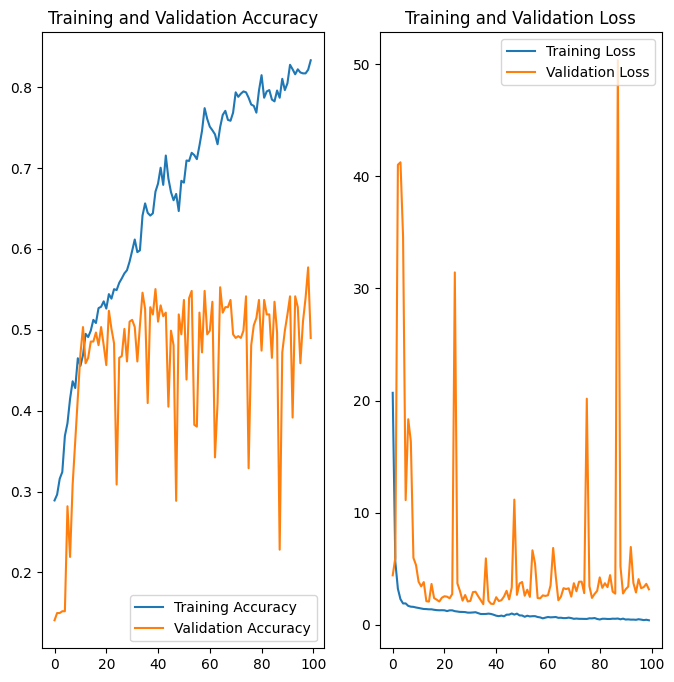

In [176]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [177]:
data_dir_test="/content/data/SkinCancerOriginal/Test/"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    labels="inferred",
    label_mode="categorical",
    class_names= ["actinic keratosis", "basal cell carcinoma", "dermatofibroma", "melanoma", "nevus",
                  "pigmented benign keratosis", "seborrheic keratosis", "squamous cell carcinoma",
                  "vascular lesion"],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
)

Found 118 files belonging to 9 classes.


In [178]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

4/4 [==============================] - 3s 36ms/step - loss: 7.0061 - accuracy: 0.3305


{'loss': 7.006053447723389, 'accuracy': 0.3305084705352783}

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

We get a training accuracy of 0.8331 and validation accuracy of 0.49 . We observe that there is overfitting. The test accuracy is 0.33 . 

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

class 0 : actinic keratosis
class 1 : basal cell carcinoma
class 2 : dermatofibroma
class 3 : melanoma
class 4 : nevus
class 5 : pigmented benign keratosis
class 6 : seborrheic keratosis
class 7 : squamous cell carcinoma
class 8 : vascular lesion


<BarContainer object of 9 artists>

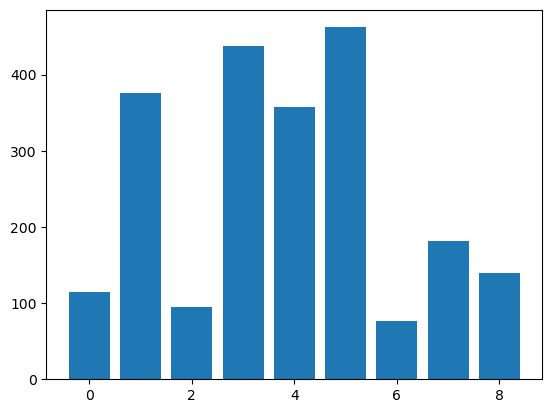

In [1]:
## Your code goes here.

label_count = [0,0,0,0,0,0,0,0,0]
class_number = [0,1,2,3,4,5,6,7,8]

for images, labels in train_ds:
    for i in range(batch_size):
        label_int = get_int_label(labels[i])
        label_count[label_int] += 1

for i in range(9):
    s = "class " + str(i) + " : " + class_names[i]
    print (s)
plt.bar(class_number, label_count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [104]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [105]:
path_to_training_dataset="/content/data/SkinCancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/data/SkinCancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F0A6D9C730>: 100%|██████████| 500/500 [00:14<00:00, 34.38 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/data/SkinCancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F0A6D47340>: 100%|██████████| 500/500 [00:14<00:00, 35.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/data/SkinCancer/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78F0A6D1F2B0>: 100%|██████████| 500/500 [00:14<00:00, 34.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/data/SkinCancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78F0A6D47D60>: 100%|██████████| 500/500 [01:23<00:00,  5.96 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/data/SkinCancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x78F12420E5F0>: 100%|██████████| 500/500 [01:16<00:00,  6.55 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/data/SkinCancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F0CB9036D0>: 100%|██████████| 500/500 [00:14<00:00, 34.62 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/data/SkinCancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78F0A3F9FDF0>: 100%|██████████| 500/500 [00:37<00:00, 13.24 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/data/SkinCancer/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78F0B03AB310>: 100%|██████████| 500/500 [00:15<00:00, 32.68 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/data/SkinCancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F0A3FF7580>: 100%|██████████| 500/500 [00:15<00:00, 33.15 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [106]:
data_dir_train = pathlib.Path("/content/data/SkinCancer/Train/")
data_dir_test = pathlib.Path("/content/data/SkinCancer/Test/")

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [108]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/data/SkinCancer/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026553.jpg_25fc0e7e-3d9d-46b8-b24b-e7b80c087684.jpg',
 '/content/data/SkinCancer/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027167.jpg_3b6e96c2-1a94-4dd4-91c5-688bf5f3bd54.jpg',
 '/content/data/SkinCancer/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027990.jpg_893f9715-002b-4c3a-885c-3551665eb40c.jpg',
 '/content/data/SkinCancer/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025627.jpg_f1d3c0fe-da3d-4886-b8b0-b91e1bf1a6f7.jpg',
 '/content/data/SkinCancer/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024708.jpg_cdb89e3f-b529-4a99-8a5d-d124715c988f.jpg',
 '/content/data/SkinCancer/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026623.jpg_7989dbf2-b9a1-4718-83b7-81de6392eb83.jpg',
 '/content/data/SkinCa

In [109]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [111]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [112]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [114]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    500
squamous cell carcinoma       500
basal cell carcinoma          500
nevus                         500
actinic keratosis             500
vascular lesion               500
dermatofibroma                500
seborrheic keratosis          500
melanoma                      500
Name: count, dtype: int64

In [117]:
!ls -lhrt /content/data/SkinCancer/Train/nevus/output/ | wc -l

501


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [122]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [123]:
data_dir_train="/content/data/SkinCancer/Train/"
(train_ds, val_ds) = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    class_names= ["actinic keratosis", "basal cell carcinoma", "dermatofibroma", "melanoma", "nevus",
                  "pigmented benign keratosis", "seborrheic keratosis", "squamous cell carcinoma",
                  "vascular lesion"],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="both",
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Using 1347 files for validation.


#### **Todo:** Create a validation dataset

#### **Todo:** Create your model (make sure to include normalization)

In [124]:
## your code goes here
### Your code goes here
model = Sequential()
model.add(Rescaling(scale = 1./255, input_shape = (180, 180, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [125]:
## your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [126]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_32 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_24 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_33 (Activation)  (None, 178, 178, 32)      0         
                                                      

#### **Todo:**  Train your model

In [127]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 43s 219ms/step - loss: 13.8960 - accuracy: 0.2661 - val_loss: 93.4542 - val_accuracy: 0.1359
Epoch 2/50
169/169 [==============================] - 35s 201ms/step - loss: 2.1462 - accuracy: 0.2969 - val_loss: 26.1434 - val_accuracy: 0.1782
Epoch 3/50
169/169 [==============================] - 34s 196ms/step - loss: 1.7609 - accuracy: 0.3591 - val_loss: 3.3172 - val_accuracy: 0.3467
Epoch 4/50
169/169 [==============================] - 35s 200ms/step - loss: 1.7336 - accuracy: 0.3724 - val_loss: 2.0074 - val_accuracy: 0.3868
Epoch 5/50
169/169 [==============================] - 35s 201ms/step - loss: 1.6610 - accuracy: 0.4006 - val_loss: 2.4111 - val_accuracy: 0.3370
Epoch 6/50
169/169 [==============================] - 35s 202ms/step - loss: 1.5849 - accuracy: 0.4167 - val_loss: 1.7398 - val_accuracy: 0.4172
Epoch 7/50
169/169 [==============================] - 34s 195ms/step - loss: 1.4607 - accuracy: 0.4423 - val_loss: 1.5943 - val

#### **Todo:**  Visualize the model results

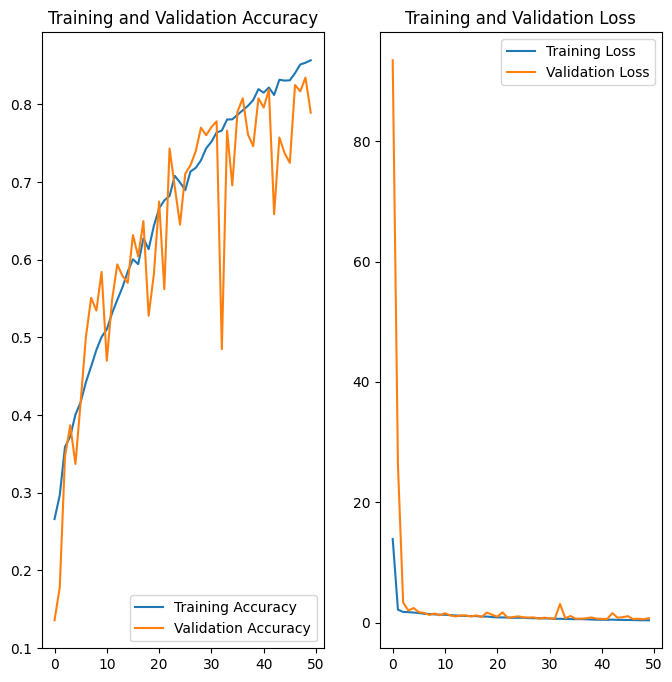

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We get a training accuracy of 0.856 and validation accuracy of 0.789 . We observe that the model is fit. The test accuracy is 0.44.

In [129]:
data_dir_test="/content/data/SkinCancer/Test/"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    labels="inferred",
    label_mode="categorical",
    class_names= ["actinic keratosis", "basal cell carcinoma", "dermatofibroma", "melanoma", "nevus",
                  "pigmented benign keratosis", "seborrheic keratosis", "squamous cell carcinoma",
                  "vascular lesion"],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
)

Found 118 files belonging to 9 classes.


In [134]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

4/4 [==============================] - 4s 37ms/step - loss: 5.7668 - accuracy: 0.4407


{'loss': 5.766836166381836, 'accuracy': 0.4406779706478119}

Conclusion:
We got a maximum test accuracy of 0.44 on Skin Cancer Multi Class Classification dataset in the 2 sets of runs.